In [1]:
# This file is to process the controlled release data from the stationary sensor leak monitoring project
# Due to the large amount of data, this file focuses on the controlled release tests.

import pandas as pd
import glob
import numpy as np

import datetime as dt
import plotly.graph_objects as go
import random

import imgkit
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.style as style
style.use('seaborn-talk')
import scipy.stats as stats

from scipy.stats import pearsonr
from matplotlib.ticker import FuncFormatter


In [2]:
# Constants

ind_buffer = '2min' #duration of time that defines an indication

# Background determined by observing initial post-installation data

gun1_bg = 30
gun2_bg = 25
heath_bg = 9
gaz_bg = 2  # assume bg is 2 ppm
quanta_bg = 2


In [3]:
# Function to load data from all 4 sensors

def load_sensor_data(path, usecols = None):
    # usecols is a list used to select columns to load into dataframe
    
    all_files = glob.glob(path + "/*.csv")
    li = []
    
    for filename in all_files:
        if "Gazomat" in path: # skip the first 2 rows of meta data in Gazomat file
            df = pd.read_csv(filename, index_col=None, header=0, skiprows = 2)
        else:
            df = pd.read_csv(filename, index_col=None, header=0, usecols=usecols)
        li.append(df)

    combined_df = pd.concat(li, axis=0, ignore_index=True, sort = False)
    
    return combined_df

In [4]:
# Function to convert time to match controlled release schedule

def convert_time(df, time_column, sensor):
    df_t = df.copy()
    
    if sensor == 'Quanta3':  # Quanta3 is in GMT so subtract 7 hours to conver to PST
        df_t[time_column] = pd.to_datetime(df_t[time_column], format = "%m/%d/%Y %H:%M:%S")    
        df_t[time_column] = df_t[time_column] - dt.timedelta(hours = 7)
        
    elif sensor == 'Sensit':
        df_t[time_column] = pd.to_datetime(df_t[time_column], format = "%m/%d/%y %H:%M:%S")
        
    else:
        df_t[time_column] = pd.to_datetime(df_t[time_column], format = "%m/%d/%Y %H:%M:%S")
        
    # Subtract an hour to account for daylight savings in 2019 which ended on Nov. 3rd 
    df_t.loc[df_t[time_column] > '2019-11-03 03:00:00', time_column] -= dt.timedelta(hours = 1)
    
    # Convert the time column to index
    df_t.index =df_t[time_column]
    
    return df_t

In [5]:
#Prepare sensit dataframe
# Time column = "Date"

df_sensit = load_sensor_data(r'Controlled release test\Sensit',
                            usecols = ['Date', 'Gun1 (ppm-m)', 'Gun2 (ppm-m)','WindSpeed (mph)', 'WindDirection'])
df_sensit.head()

,Date,Gun1 (ppm-m),Gun2 (ppm-m),WindSpeed (mph),WindDirection
0,05/22/19 12:45:10,1.55,7.53,0.0,0.0
1,05/22/19 12:45:20,0.36,18.27,0.0,0.0
2,05/22/19 12:45:51,17.03,10.60,0.0,0.0
3,05/22/19 12:49:52,26.78,8.89,0.0,0.0
4,05/22/19 12:50:03,29.53,17.67,0.0,0.0


In [6]:
# Prepare Gazomat dataframe
# Time column = "Reading DateTime"

df_gaz = load_sensor_data(r'Controlled release test\Gazomat')
df_gaz.drop(['Station Name', 'IoT serial Number'], axis = 1, inplace=True)
df_gaz.tail()

,Reading DateTime,CH4,Sample AirFlow
62157,11/8/2019 19:09:48,2.1,1.5
62158,11/8/2019 19:10:03,2.1,1.5
62159,11/8/2019 19:10:18,2.0,1.5
62160,11/8/2019 19:10:33,2.0,1.5
62161,11/8/2019 19:10:48,1.9,1.5


In [7]:
# Prepare Quanta3 dataframe
# Time column = "Date/Time"
df_quanta = load_sensor_data(r'Controlled release test\Quanta3',
                            usecols=['Date/Time', 'CONC', 'ACT_WIND_SPEED', 'ACT_WIND_DIR'])
df_quanta.tail()

,Date/Time,CONC,ACT_WIND_SPEED,ACT_WIND_DIR
968395,11/7/2019 23:59:55,1.79354,4.23662,10.00488
968396,11/7/2019 23:59:56,1.81715,3.95981,15.20910
968397,11/7/2019 23:59:57,1.83772,3.87989,2.96162
968398,11/7/2019 23:59:58,1.83772,4.19210,10.54315
968399,11/7/2019 23:59:59,1.80887,4.24671,357.54967


In [8]:
# Prepare Heath dataframe
# Time column = 'Device Local Time'
df_heath = load_sensor_data(r'Controlled release test\Heath',
                            usecols=['Ch4 Average', 'Wind Speed', 'Wind Direction', 'F1', 'F2','Device Local Time'])
df_heath.tail()

,Ch4 Average,Wind Speed,Wind Direction,F1,F2,Device Local Time
192005,14.0,2.0,168.0,90.06,0.88,11/8/2019 23:59:30
192006,10.0,2.0,168.0,90.06,0.88,11/8/2019 23:59:36
192007,11.0,2.0,166.0,90.06,0.88,11/8/2019 23:59:42
192008,15.0,2.0,168.0,90.06,0.88,11/8/2019 23:59:48
192009,15.0,3.0,165.0,90.06,0.88,11/8/2019 23:59:54


In [9]:
# Subtracted one hour after daylight savings ended on Nov 3rd 2019,
# Converted Quanta3 GMT time to PST by subtracting 7 hours

df_sensit_temp = convert_time(df_sensit, "Date", "Sensit")
df_gaz_t = convert_time(df_gaz, "Reading DateTime", "Gazomat")
df_quanta_t = convert_time(df_quanta, "Date/Time", "Quanta3")
df_heath_t = convert_time(df_heath, "Device Local Time", "Heath")

In [10]:
# Gun 1 and Gun 2 are swapped on June 20th at 2PM. Gun1 and Gun2 data before this time should be swapped
# so the definition is that Gun 1 is facing SE, Gun 2 is facing SW

df_sensit_t = df_sensit_temp.copy()

# Read above
df_sensit_t.loc[:'2019-06-20 14:00:00', 'Gun1 (ppm-m)'] = df_sensit_temp.loc[:'2019-06-20 14:00:00', 'Gun2 (ppm-m)']
df_sensit_t.loc[:'2019-06-20 14:00:00', 'Gun2 (ppm-m)'] = df_sensit_temp.loc[:'2019-06-20 14:00:00', 'Gun1 (ppm-m)']
df_sensit_t.head()

,Date,Gun1 (ppm-m),Gun2 (ppm-m),WindSpeed (mph),WindDirection
Date,,,,,
2019-05-22 12:45:10,2019-05-22 12:45:10,7.53,1.55,0.0,0.0
2019-05-22 12:45:20,2019-05-22 12:45:20,18.27,0.36,0.0,0.0
2019-05-22 12:45:51,2019-05-22 12:45:51,10.60,17.03,0.0,0.0
2019-05-22 12:49:52,2019-05-22 12:49:52,8.89,26.78,0.0,0.0
2019-05-22 12:50:03,2019-05-22 12:50:03,17.67,29.53,0.0,0.0


In [11]:
# Only keep data that are during controlled release tests

# Load list of controlled release tests time and duration
df_cont = pd.read_csv(r'Controlled release test\Releases_schedule.csv')

# Append date to start and end times to make it datetime ready
df_cont['Start_time'] = pd.to_datetime(df_cont['Date'] + ' ' + df_cont['Start_time'], format ='%m/%d/%Y %H:%M')
df_cont['End_time'] = pd.to_datetime(df_cont['Date'] + ' ' + df_cont['End_time'], format ='%m/%d/%Y %H:%M')

df_cont.tail()

,Number,Date,Start_time,End_time,Flow_rate_scfh,Duration,Description,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Date.1,Start time,End time,Protocol used
28,29,11/5/2019,2019-11-05 09:23:00,2019-11-05 09:33:00,20,10,Controlled release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,30,11/5/2019,2019-11-05 09:34:00,2019-11-05 09:44:00,35,10,Controlled release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,31,11/5/2019,2019-11-05 09:46:00,2019-11-05 09:56:00,60,10,Controlled release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,32,11/5/2019,2019-11-05 09:58:00,2019-11-05 10:08:00,100,10,Controlled release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,33,11/5/2019,2019-11-05 10:09:00,2019-11-05 10:19:00,150,10,Controlled release,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# COMPLETED
# 1. For each row of the df_cont table, extract that data slice from each sensor's dataframe:
    #a For each sensor dataframe:
        #- section the data into groups of 120 secs (2 mins)
        #- scan for readings above 2x background
        #- add count of time sections above 2 mins to a column on df_cont
        #- add highest read (normalized by background) to a column on df_cont
        #- add highest area under curve of time sections to a column on df_cont
            #- for each time section, get the positive difference between reading and bg, normalize by bg
            #- Multiply the excess concentration with the time step of the sensor 
            #- Sum all the products of excess conc. with time step in each time section (in seconds).
    #b Add avg. wind speed column(s) to df_cont, based on Sensit/Heath/Quanta3 data sets, create one for each
    #c Add avg. wind direction column(s) to df_cont, based on Sensit/Heath/Quanta3 data sets, create one for each

In [13]:
# This box serves no purpose
# Function to add processed data into the controlled releases dataframe

def add_cont(df_cont):
    df = df_cont.copy()
    
    # Create a new column with average wind speed during the slice of time bounded by Start_time and End_time
    df['sensit_avg_w_spd'] = df_sensit_t.loc[(df_sensit_t['Date'] >= df['Start_time']) & 
                                         (df_sensit_t['Date'] <= df['End_time']),
                                         'WindSpeed (mph)'].mean()
 #   df['heath_avg_w_spd'] = df_heath_t.loc[df['Start_time']: df['End_time'], 'Wind Speed'].mean()
 #   df['quanta_avg_w_spd'] =df_quanta_t.loc[df['Start_time']: df['End_time'], 'ACT_WIND_SPEED'].mean()
                                            
    return df

In [14]:
def avg_wind_spd_and_direction(w_spd, w_dir):
    """ Function to calculate average wind speed and direction
        using vector method
        
        :param w_spd: wind speed data as a pd.Series
        :param w_dir: wind direction data as a pd.Series
        :return avg_wind_spd, avg_wind_dir    
    """
    V_east = (w_spd * np.sin(w_dir / 180 * np.pi)).mean()
    V_north = (w_spd * np.cos(w_dir / 180 * np.pi)).mean()
    avg_wind_spd = w_spd.mean()
    avg_wind_dir = np.arctan2(V_east, V_north) * 180 / np.pi
    avg_wind_dir = (360 + avg_wind_dir) % 360
    
    return avg_wind_spd, avg_wind_dir

In [15]:
def max_auc_indications(conc, bg):
    """ Function to retrieve normalized maximum concentration, calculate 
        normalized area under concentration curve, and number of indications 
        during the release test. Indication is grouped every 2 minutes.
        
        :param conc: concentration readings as a pd.Series
        :param bg: background reading as a float
        :return: returns the normalized maximum, auc score, number of indications for the period
    """
    norm_max = conc.max() / bg
    
    timedelta = (conc.index[1]-conc.index[0]).seconds # in seconds
    norm_diff = (conc - bg).clip(lower=0) / bg # diff of concentration in ppm normalized by background value, min is zero
    auc = (norm_diff * timedelta).sum() 
    
    threshold = 2 * bg
    # an indication is produced if the max concentration exceeds threshold in a 2-min interval, return count of indications
    num_ind = (conc.groupby(pd.Grouper(freq=ind_buffer)).max() > threshold).sum()
    
    return norm_max, auc, num_ind

In [16]:
# Create empty lists to store wind and concentration metrics
# average wind speed, wind direction
# max concentration, area under curve, number of indications data
sensit_w_spd = []
heath_w_spd = []
quanta_w_spd= []

sensit_w_dir = []
heath_w_dir = []
quanta_w_dir= []

gun1_max_conc = []
gun2_max_conc = []
heath_max_conc = []
gaz_max_conc = []
quanta_max_conc = []

gun1_conc_auc = []
gun2_conc_auc = []
heath_conc_auc = []
gaz_conc_auc = []
quanta_conc_auc =[]

gun1_num_ind = []
gun2_num_ind = []
heath_num_ind = []
gaz_num_ind = []
quanta_num_ind = []

# Calculate average wind and concentration metrics for each slice of time of controlled release test.
# Doing iterrow is not ideal in Python, but there was an issue with trying to slice sensor
# dataframe using TimeStamp values in the df_cont dataframe.

for index, row in df_cont.iterrows():
    
    # This section slices the data from the sensor dataframes and calculates the average wind speed and direction
    # Note that df.columns.intersection[list] is used instead of the slicing with [[list]] because of the column names
    # change, this code won't throw an error but will just slice the columns that exist
    
    sensit_data = df_sensit_t.loc[str(row['Start_time']):str(row['End_time']), 
                                  df_sensit_t.columns.intersection(['Gun1 (ppm-m)', 'Gun2 (ppm-m)','WindSpeed (mph)','WindDirection'])]
    sensit_spd, sensit_dir = avg_wind_spd_and_direction(sensit_data.iloc[:,2], sensit_data.iloc[:,3])
    sensit_w_spd.append(sensit_spd)
    sensit_w_dir.append(sensit_dir)
 
    heath_data = df_heath_t.loc[str(row['Start_time']):str(row['End_time']), 
                                df_heath_t.columns.intersection(['Ch4 Average', 'Wind Speed', 'Wind Direction'])]
    heath_spd, heath_dir = avg_wind_spd_and_direction(heath_data.iloc[:,1], heath_data.iloc[:,2])
    heath_w_spd.append(heath_spd)
    heath_w_dir.append(heath_dir)
    
    quanta_data = df_quanta_t.loc[str(row['Start_time']):str(row['End_time']), 
                                  df_quanta_t.columns.intersection(['CONC','ACT_WIND_SPEED', 'ACT_WIND_DIR'])]
    quanta_spd, quanta_dir = avg_wind_spd_and_direction(quanta_data.iloc[:,1], quanta_data.iloc[:,2])
    quanta_w_spd.append(quanta_spd)
    quanta_w_dir.append(quanta_dir)
    
    # This section calculates the concentration related metrics
    
    gun1_max, gun1_auc, gun1_ind = max_auc_indications(sensit_data['Gun1 (ppm-m)'], gun1_bg)
    gun2_max, gun2_auc, gun2_ind = max_auc_indications(sensit_data['Gun2 (ppm-m)'], gun2_bg)
    heath_max, heath_auc, heath_ind = max_auc_indications(heath_data['Ch4 Average'], heath_bg)
    quanta_max, quanta_auc, quanta_ind = max_auc_indications(quanta_data['CONC'], quanta_bg)
    
    gun1_max_conc.append(gun1_max)
    gun1_conc_auc.append(gun1_auc)
    gun1_num_ind.append(gun1_ind)
    
    gun2_max_conc.append(gun2_max)
    gun2_conc_auc.append(gun2_auc)
    gun2_num_ind.append(gun2_ind)
    
    heath_max_conc.append(heath_max)
    heath_conc_auc.append(heath_auc)
    heath_num_ind.append(heath_ind)
      
    quanta_max_conc.append(quanta_max)
    quanta_conc_auc.append(quanta_auc)
    quanta_num_ind.append(quanta_ind) 
    
    # Gazomat was installed after the first release test was completed, so skip first test
    if index == 0:
        gaz_max_conc.append(np.nan)
        gaz_conc_auc.append(np.nan)
        gaz_num_ind.append(np.nan)
        
    else:
        gaz_data = df_gaz_t.loc[str(row['Start_time']):str(row['End_time']), 
                            df_gaz_t.columns.intersection(['CH4', 'Sample AirFlow'])]
        gaz_max, gaz_auc, gaz_ind = max_auc_indications(gaz_data['CH4'], gaz_bg)
        
        gaz_max_conc.append(gaz_max)
        gaz_conc_auc.append(gaz_auc)
        gaz_num_ind.append(gaz_ind)

C:\Users\GBong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in double_scalars



In [17]:
# Quanta3 wind data is in m/s, Heath and Sensit are in mph. 
b = pd.DataFrame({'sensit_w_spd': sensit_w_spd,
                'heath_w_spd': heath_w_spd,
                'quanta_w_spd': quanta_w_spd,
                'sensit_w_dir': sensit_w_dir,
                'heath_w_dir': heath_w_dir,
                'quanta_w_dir': quanta_w_dir,
                  
                'gun1_max_conc': gun1_max_conc,
                'gun2_max_conc': gun2_max_conc,
                'heath_max_conc': heath_max_conc,
                'gaz_max_conc': gaz_max_conc,
                'quanta_max_conc': quanta_max_conc,

                'gun1_conc_auc':gun1_conc_auc,
                'gun2_conc_auc':gun2_conc_auc,
                'heath_conc_auc':heath_conc_auc,
                'gaz_conc_auc':gaz_conc_auc,
                'quanta_conc_auc':quanta_conc_auc,

                'gun1_num_ind':gun1_num_ind,
                'gun2_num_ind':gun2_num_ind,
                'heath_num_ind':heath_num_ind,
                'gaz_num_ind':gaz_num_ind,
                'quanta_num_ind':quanta_num_ind})

# Multiply Quanta3 w_speed by 2.237 to convert from m/s to mph
b['quanta_w_spd'] *= 2.237 

#concat the w_speed data to the controlled release dataframe
df_cont_c = pd.concat([df_cont.copy(), b], axis= 1)


In [18]:
# 2. Visualization of the data
#    WIND metrics
# a. Compute average of the w_spd and w_dir columns into new columns 'avg_w_spd' and 'avg_w_dir'

#    CONCENTRATION metrics
# a. Plot num_ind/auc vs. w_spd
# b. Polar plot of num_ind/auc vs. w_dir
# c. plot num_ind vs. leak size for all sensors
# d. plot auc vs. leak size for all sensors


In [19]:
# Create new column for average wind speed in mph
df_cont_c['avg_w_spd'] = df_cont_c[['sensit_w_spd', 'heath_w_spd', 'quanta_w_spd']].mean(axis=1)

# Column stating if wind speed is high or low (< 6 mph)
df_cont_c['w_spd'] = ['low' if x < 6 else 'high' for x in df_cont_c['avg_w_spd']]

# Create a new column for average wind direction in degrees
avg_w_dir = []
for index, row in df_cont_c.iterrows():
    # Create new column for average wind direction
    _, w = avg_wind_spd_and_direction(pd.Series([row['sensit_w_spd'], row['heath_w_spd'], row['quanta_w_spd']]),
                                pd.Series([row['sensit_w_dir'], row['heath_w_dir'], row['quanta_w_dir']]))
    avg_w_dir.append(w)
    
df_cont_c['avg_w_dir'] = pd.Series(avg_w_dir)

# Column specifying if wind direction is South or North
df_cont_c['w_dir'] = ['Northerly' if x < 90 or x >= 270 else 'Southerly' for x in df_cont_c['avg_w_dir']]

In [20]:
df_cont_c.head()

,Number,Date,Start_time,End_time,Flow_rate_scfh,Duration,Description,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,quanta_conc_auc,gun1_num_ind,gun2_num_ind,heath_num_ind,gaz_num_ind,quanta_num_ind,avg_w_spd,w_spd,avg_w_dir,w_dir
0,1,5/22/2019,2019-05-22 13:48:00,2019-05-22 13:58:00,100,10,Controlled release,NaN,NaN,NaN,...,135.257970,0,2,3,NaN,0,9.652094,high,319.041560,Northerly
1,2,5/22/2019,2019-05-22 15:37:00,2019-05-22 15:50:00,100,13,Controlled release,NaN,NaN,NaN,...,230.531570,0,7,8,7.0,0,4.972825,low,269.647543,Southerly
2,3,5/23/2019,2019-05-23 08:35:00,2019-05-23 08:47:00,100,12,Controlled release,NaN,NaN,NaN,...,704.849600,4,6,0,7.0,4,11.188664,high,203.583548,Southerly
3,4,7/9/2019,2019-07-09 09:27:00,2019-07-09 09:37:00,10,10,Controlled release,NaN,NaN,NaN,...,345.679250,3,5,6,6.0,2,6.286890,high,196.015311,Southerly
4,5,7/9/2019,2019-07-09 09:38:00,2019-07-09 09:48:00,10,10,Controlled release,NaN,NaN,NaN,...,179.490175,2,1,3,5.0,0,8.713522,high,205.968733,Southerly


In [21]:
# create a dataframe with just the number of indications data
df_num_ind = df_cont_c[['Date', 'Flow_rate_scfh', 'w_spd', 'w_dir', 'avg_w_spd',
             'gun1_num_ind', 'gun2_num_ind', 
             'heath_num_ind', 'gaz_num_ind', 
             'quanta_num_ind']].melt(id_vars=['Date', 'Flow_rate_scfh', 'avg_w_spd',
                                              'w_spd', 'w_dir',],
                                     value_vars=['gun1_num_ind', 'gun2_num_ind', 
                                                 'heath_num_ind', 'gaz_num_ind', 
                                                 'quanta_num_ind'],
                                     var_name = 'sensor',
                                     value_name = 'num_indications')

df_num_ind = df_num_ind[df_num_ind.Flow_rate_scfh != 500]
df_num_ind['sensor'].replace({'gun1_num_ind': 'Sensit Gun 1', 'gun2_num_ind': 'Sensit Gun 2', 
                              'heath_num_ind': 'Heath', 'gaz_num_ind': 'Gazomat', 
                              'quanta_num_ind': 'Quanta3'}, inplace=True)
df_num_ind.head(10)

,Date,Flow_rate_scfh,avg_w_spd,w_spd,w_dir,sensor,num_indications
0,5/22/2019,100,9.652094,high,Northerly,Sensit Gun 1,0.0
1,5/22/2019,100,4.972825,low,Southerly,Sensit Gun 1,0.0
2,5/23/2019,100,11.188664,high,Southerly,Sensit Gun 1,4.0
3,7/9/2019,10,6.286890,high,Southerly,Sensit Gun 1,3.0
4,7/9/2019,10,8.713522,high,Southerly,Sensit Gun 1,2.0
5,7/9/2019,20,7.959310,high,Southerly,Sensit Gun 1,1.0
6,7/9/2019,35,7.248806,high,Southerly,Sensit Gun 1,4.0
7,7/9/2019,60,7.757120,high,Southerly,Sensit Gun 1,5.0
8,7/9/2019,100,7.501605,high,Southerly,Sensit Gun 1,5.0
9,7/9/2019,150,8.905090,high,Southerly,Sensit Gun 1,6.0


In [22]:
# Plot total number of indications detected by each sensor
df_num_ind_grouped = df_num_ind.groupby('sensor').sum()
df_num_ind_grouped['sensor'] = df_num_ind_grouped.index
df_num_ind_grouped 

,Flow_rate_scfh,avg_w_spd,num_indications,sensor
sensor,,,,
Gazomat,1950,167.146553,107.0,Gazomat
Heath,1950,167.146553,72.0,Heath
Quanta3,1950,167.146553,29.0,Quanta3
Sensit Gun 1,1950,167.146553,72.0,Sensit Gun 1
Sensit Gun 2,1950,167.146553,81.0,Sensit Gun 2


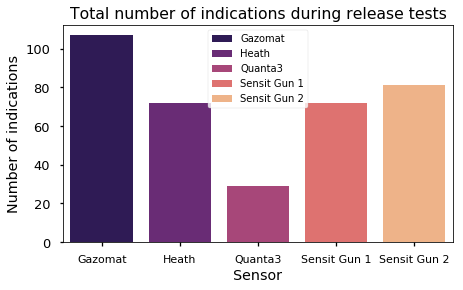

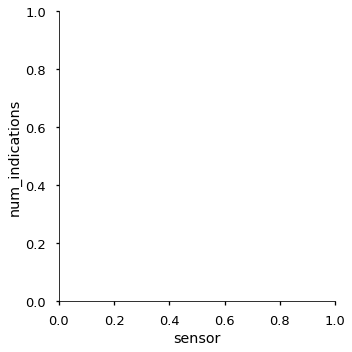

In [23]:
fig, ax = plt.subplots(1, 1, figsize =(7, 4))
g= sns.catplot(x='sensor', y="num_indications", kind='bar',
                hue='sensor', data=df_num_ind_grouped, 
                dodge=False, ci=False, palette='magma', legend = True, ax=ax)
ax.legend(loc='upper center', fontsize='medium')
ax.set_title('Total number of indications during release tests', loc='center')
ax.set_ylabel('Number of indications')
ax.set_xlabel('Sensor')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_tick_params(labelsize=11)


Text(0.5, 6.799999999999997, 'Flow rate (cfh)')

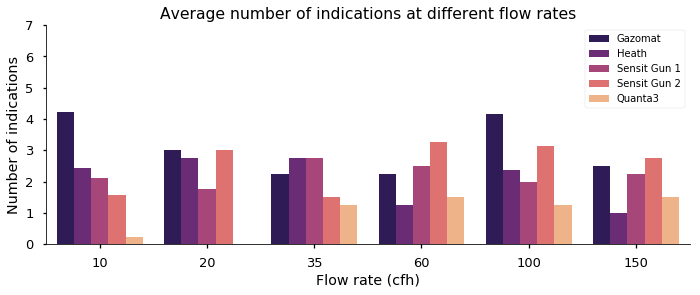

In [24]:
g = sns.catplot(x="Flow_rate_scfh", y="num_indications", kind='bar',
                hue="sensor", data=df_num_ind, 
                height = 4, aspect = 2.5,
                hue_order = ['Gazomat', 'Heath', 'Sensit Gun 1', 'Sensit Gun 2', 'Quanta3'],
                dodge=True, ci=None, palette='magma',
                legend = False)
plt.ylim(top=7)
plt.legend(loc='upper right', fontsize='medium')
plt.title('Average number of indications at different flow rates', loc='center')
plt.ylabel('Number of indications')
plt.xlabel('Flow rate (cfh)')


C:\Users\GBong\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



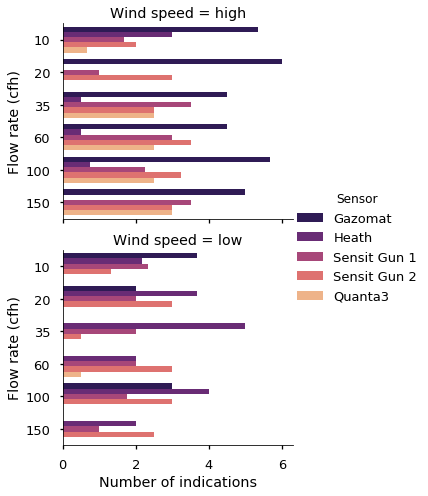

In [25]:
df_num_ind_plot = df_num_ind.copy()
df_num_ind_plot.rename(columns = {'num_indications': 'Number of indications',
                   'Flow_rate_scfh' : 'Flow rate (cfh)',
                   'w_spd' : 'Wind speed',
                   'w_dir' : 'Wind direction',
                   'avg_w_spd': 'Wind speed (mph)'}, inplace = True)

g = sns.catplot(x="Number of indications", y="Flow rate (cfh)",
                 hue="sensor", row="Wind speed",
                 data=df_num_ind_plot, legend_out = True,
                 orient="h", height=3.5, aspect=1.3, palette="magma",
                 hue_order = ['Gazomat', 'Heath', 'Sensit Gun 1', 'Sensit Gun 2', 'Quanta3'],
                 kind="bar", ci= False)

g._legend.set_title('Sensor')
# new_labels=['Sensit Gun 1', 'Sensit Gun 2', 'Heath', 'Gazomat', 'Quanta3']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)


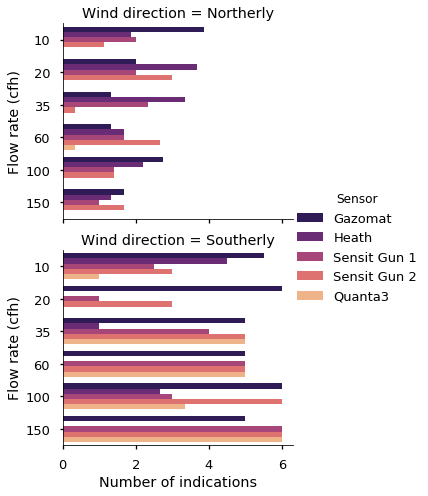

In [26]:
g = sns.catplot(x="Number of indications", y="Flow rate (cfh)",
                 hue="sensor", row="Wind direction",
                 data=df_num_ind_plot, legend_out = True,
                 orient="h", height=3.5, aspect=1.3, palette="magma",
                 hue_order = ['Gazomat', 'Heath', 'Sensit Gun 1', 'Sensit Gun 2', 'Quanta3'],
                 kind="bar", ci= False)

g._legend.set_title('Sensor')
# new_labels=['Sensit Gun 1', 'Sensit Gun 2', 'Heath', 'Gazomat', 'Quanta3']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)


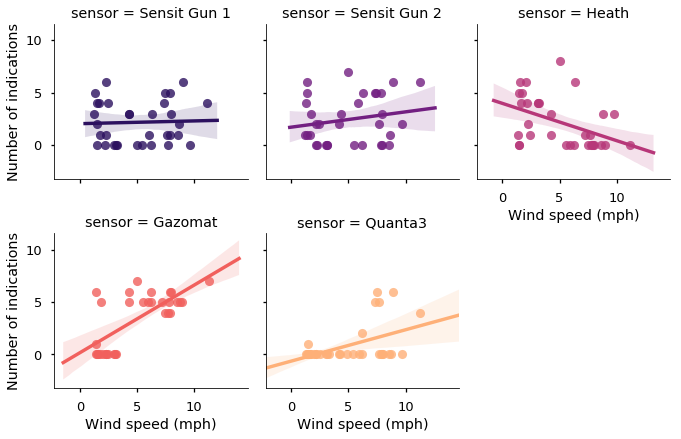

In [27]:
# Plot a linear regression fit of num of indications vs. wind speed
g = sns.lmplot(x="Wind speed (mph)", y="Number of indications", 
               hue="sensor", col='sensor',
               col_wrap = 3,
               palette='magma', data=df_num_ind_plot, 
               height=3.1, aspect=1.05, x_jitter=.1)


In [28]:
# create a dataframe with the AUC data
df_conc_auc = df_cont_c[['Date', 'Flow_rate_scfh', 'w_spd', 'w_dir','avg_w_spd', 'Start_time',
             'gun1_conc_auc', 'gun2_conc_auc', 
             'heath_conc_auc', 'gaz_conc_auc', 
             'quanta_conc_auc']].melt(id_vars=['Date', 'Flow_rate_scfh','avg_w_spd','Start_time',
                                               'w_spd', 'w_dir'],
                                     value_vars=['gun1_conc_auc', 'gun2_conc_auc', 
                                                 'heath_conc_auc', 'gaz_conc_auc', 
                                                 'quanta_conc_auc'],
                                     var_name = 'sensor',
                                     value_name = 'concentration AUC score')

df_conc_auc['sensor'].replace({'gun1_conc_auc': 'Sensit Gun 1', 'gun2_conc_auc': 'Sensit Gun 2', 
                              'heath_conc_auc': 'Heath', 'gaz_conc_auc': 'Gazomat', 
                              'quanta_conc_auc': 'Quanta3'}, inplace=True)

df_conc_auc = df_conc_auc[df_conc_auc.Flow_rate_scfh != 500]
#df_conc_auc['concentration AUC score'] = np.log(df_conc_auc['concentration AUC score'])
# df_conc_auc['concentration AUC score'] = np.log2(df_conc_auc['concentration AUC score'],
#                                                  out=np.zeros_like(df_conc_auc['concentration AUC score']),
#                                                  where=(df_conc_auc['concentration AUC score']!=0))
df_conc_auc.tail(10)

,Date,Flow_rate_scfh,avg_w_spd,Start_time,w_spd,w_dir,sensor,concentration AUC score
155,9/24/2019,60,7.632822,2019-09-24 10:54:00,high,Northerly,Quanta3,0.000000
156,9/24/2019,100,7.820027,2019-09-24 11:05:00,high,Northerly,Quanta3,0.000000
157,9/24/2019,150,8.594854,2019-09-24 11:16:00,high,Northerly,Quanta3,0.000000
158,11/5/2019,10,1.285655,2019-11-05 09:02:00,low,Northerly,Quanta3,41.207020
159,11/5/2019,10,1.773196,2019-11-05 09:13:00,low,Northerly,Quanta3,120.077225
160,11/5/2019,20,1.480501,2019-11-05 09:23:00,low,Northerly,Quanta3,78.893920
161,11/5/2019,35,2.097029,2019-11-05 09:34:00,low,Northerly,Quanta3,102.058495
162,11/5/2019,60,3.212687,2019-11-05 09:46:00,low,Northerly,Quanta3,75.860760
163,11/5/2019,100,3.120058,2019-11-05 09:58:00,low,Northerly,Quanta3,56.766190
164,11/5/2019,150,3.084025,2019-11-05 10:09:00,low,Northerly,Quanta3,49.229990


In [29]:
df_conc_auc_grouped = df_conc_auc.groupby('sensor').sum()
df_conc_auc_grouped['sensor'] = df_conc_auc_grouped.index
df_conc_auc_grouped['concentration AUC score'] = df_conc_auc_grouped['concentration AUC score'].round(0)
df_conc_auc_grouped

,Flow_rate_scfh,avg_w_spd,concentration AUC score,sensor
sensor,,,,
Gazomat,1950,167.146553,103069.0,Gazomat
Heath,1950,167.146553,22397.0,Heath
Quanta3,1950,167.146553,5969.0,Quanta3
Sensit Gun 1,1950,167.146553,16286.0,Sensit Gun 1
Sensit Gun 2,1950,167.146553,27816.0,Sensit Gun 2


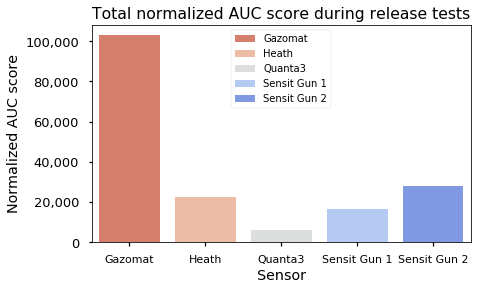

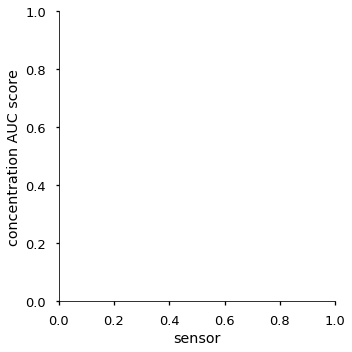

In [30]:
fig, ax = plt.subplots(1, 1, figsize =(6.8, 4))
g= sns.catplot(x='sensor', y="concentration AUC score", kind='bar',
                hue='sensor', data=df_conc_auc_grouped, 
                dodge=False, ci=False, palette='coolwarm_r', legend = True, ax=ax)
ax.legend(loc='upper center', fontsize='medium')
ax.set_title('Total normalized AUC score during release tests', loc='center')
ax.set_ylabel('Normalized AUC score')
ax.set_xlabel('Sensor')
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax.xaxis.set_tick_params(labelsize=11)
plt.tight_layout()


Text(0.5, 1.0, 'Average normalized AUC score for each run at different flow rates')

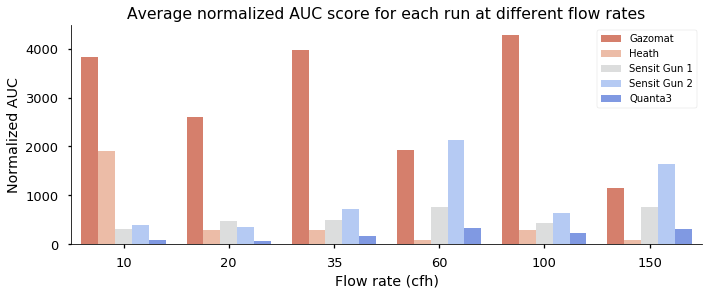

In [31]:
df_conc_auc_plot = df_conc_auc.copy()
df_conc_auc_plot.rename(columns = {'concentration AUC score': 'Normalized AUC',
                   'Flow_rate_scfh' : 'Flow rate (cfh)',
                   'w_spd' : 'Wind speed',
                   'w_dir' : 'Wind direction',
                   'avg_w_spd': 'Wind speed (mph)'}, inplace = True)

g = sns.catplot(x="Flow rate (cfh)", y="Normalized AUC", kind='bar',
                hue="sensor", data=df_conc_auc_plot, 
                height = 4, aspect = 2.5,
                hue_order = ['Gazomat', 'Heath', 'Sensit Gun 1', 'Sensit Gun 2', 'Quanta3'],
                dodge=True, ci=None, palette='coolwarm_r',
                legend = False)
plt.legend(loc='upper right', fontsize='medium')
plt.title('Average normalized AUC score for each run at different flow rates', loc='center')


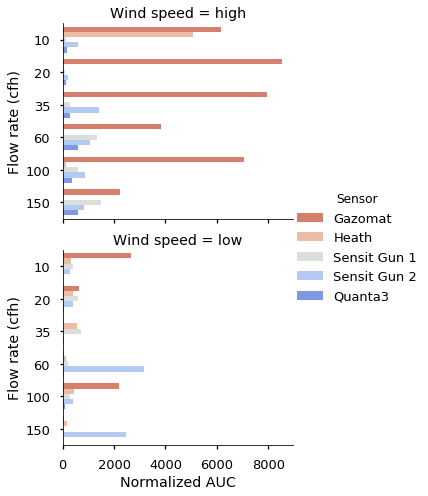

In [32]:
g = sns.catplot(x="Normalized AUC", y="Flow rate (cfh)",
                 hue="sensor", row="Wind speed",
                 data=df_conc_auc_plot, legend_out = True,
                 orient="h", height=3.5, aspect=1.3, palette="coolwarm_r",
                 hue_order = ['Gazomat', 'Heath', 'Sensit Gun 1', 'Sensit Gun 2', 'Quanta3'],
                 kind="bar", ci= False)

g._legend.set_title('Sensor')
# new_labels=['Sensit Gun 1', 'Sensit Gun 2', 'Heath', 'Gazomat', 'Quanta3']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)


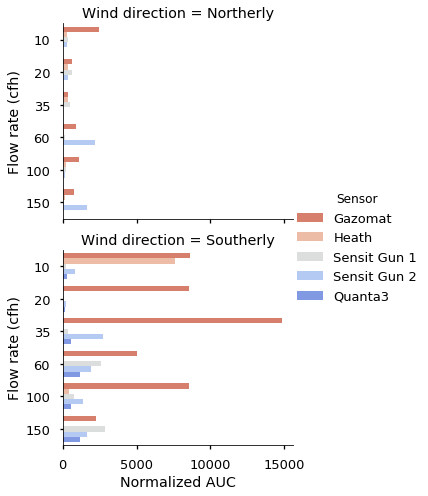

In [33]:
g = sns.catplot(x="Normalized AUC", y="Flow rate (cfh)",
                 hue="sensor", row="Wind direction",
                 data=df_conc_auc_plot, legend_out = True,
                 orient="h", height=3.5, aspect=1.3, palette="coolwarm_r",
                 hue_order = ['Gazomat', 'Heath', 'Sensit Gun 1', 'Sensit Gun 2', 'Quanta3'],
                 kind="bar", ci= False)

g._legend.set_title('Sensor')


(-3000, 16000)

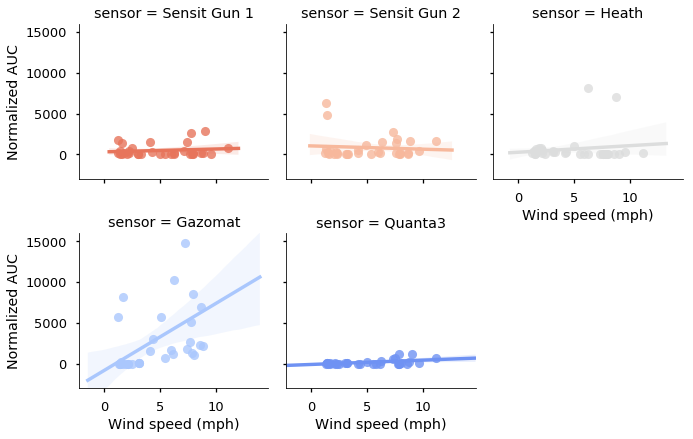

In [34]:
# Plot a linear regression fit of concentration AUC score vs. wind speed
g = sns.lmplot(x="Wind speed (mph)", y="Normalized AUC", 
               hue="sensor", col='sensor',
               col_wrap = 3,
               palette=sns.color_palette('coolwarm_r',n_colors=5, desat = 1), data=df_conc_auc_plot, 
               height=3.1, aspect=1.05, x_jitter=.1)

plt.ylim(bottom=-3000 , top= 16000)


Text(0, 0.5, '')

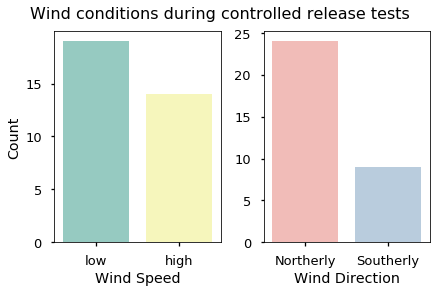

In [35]:
# plot the count of low/high wind speed during the controlled release tests

fig, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2, 
                                 figsize=(6,4), constrained_layout=True)

fig.suptitle('Wind conditions during controlled release tests',
             fontsize=16,
             ha='center',
             va='top')

sns.countplot(x='w_spd', data=df_cont_c, 
                   order =['low','high'], palette ='Set3', ax=ax1)

ax1.set_xlabel('Wind Speed')
ax1.set_ylabel('Count')
ax1.set_yticks(np.arange(0, 20, 5))

# plot the count of Southerly or Northerly wind directions during the controlled release tests

sns.countplot(x='w_dir', data=df_cont_c, 
               palette ='Pastel1', ax=ax2)

ax2.set_xlabel('Wind Direction')
ax2.set_ylabel('')


Text(0.5, 0.98, 'Distribution of variables during controlled release tests')

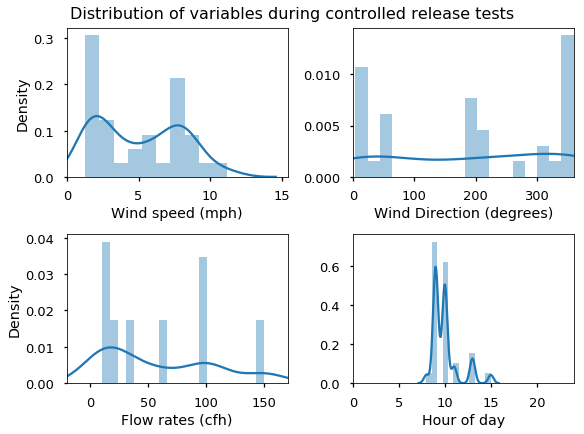

In [36]:
# Plot distribution of wind speed, wind direction, flow rate, and hour of day during controlled tests

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, 
                                             figsize=(8,6), constrained_layout=True)

#wind speed
sns.distplot(df_conc_auc['avg_w_spd'],
                 rug=False, bins = 10, ax=ax1)

ax1.set_xlabel('Wind speed (mph)')
ax1.set_xlim(left = 0)
ax1.set_ylabel('Density')

#wind direction
sns.distplot(df_cont_c['avg_w_dir'],
                 rug=False, bins = 18, ax=ax2)

ax2.set_xlabel('Wind Direction (degrees)')
ax2.set_xlim(left = 0, right =360)
ax2.set_ylabel('')

# flow rate
sns.distplot(df_conc_auc['Flow_rate_scfh'],
                 rug=False, bins = 20, ax=ax3)

ax3.set_xlabel('Flow rates (cfh)')
ax3.set_xlim(left = -20, right = 170)
ax3.set_ylabel('Density')

# hour of day
sns.distplot(df_conc_auc['Start_time'].dt.hour,
                 rug=False, bins = 12, ax=ax4)

ax4.set_xlabel('Hour of day')
ax4.set_xlim(left = 0, right = 24)
ax4.set_ylabel('')

fig.suptitle('Distribution of variables during controlled release tests', 
             fontsize=16,
             ha='center',
             va='top')


In [37]:
df_num_ind_no_na = df_num_ind.dropna(axis=0, how='any') # drop rows with missing values
df_num_ind_no_na[df_num_ind_no_na['sensor'] == 'Gazomat']

,Date,Flow_rate_scfh,avg_w_spd,w_spd,w_dir,sensor,num_indications
100,5/22/2019,100,4.972825,low,Southerly,Gazomat,7.0
101,5/23/2019,100,11.188664,high,Southerly,Gazomat,7.0
102,7/9/2019,10,6.286890,high,Southerly,Gazomat,6.0
103,7/9/2019,10,8.713522,high,Southerly,Gazomat,5.0
104,7/9/2019,20,7.959310,high,Southerly,Gazomat,6.0
105,7/9/2019,35,7.248806,high,Southerly,Gazomat,5.0
106,7/9/2019,60,7.757120,high,Southerly,Gazomat,5.0
107,7/9/2019,100,7.501605,high,Southerly,Gazomat,4.0
108,7/9/2019,150,8.905090,high,Southerly,Gazomat,5.0
109,8/20/2019,10,2.203914,low,Northerly,Gazomat,0.0


In [38]:
# show if there are correlation between different sensors' number of indications

df_corr_ind = df_cont_c[['gun1_num_ind', 'gun2_num_ind', 'heath_num_ind',
           'gaz_num_ind', 'quanta_num_ind']] 

df_corr_ind.corr()

,gun1_num_ind,gun2_num_ind,heath_num_ind,gaz_num_ind,quanta_num_ind
gun1_num_ind,1.000000,0.534782,-0.308365,-0.010614,0.599017
gun2_num_ind,0.534782,1.000000,-0.067636,0.298010,0.606946
heath_num_ind,-0.308365,-0.067636,1.000000,-0.285357,-0.317357
gaz_num_ind,-0.010614,0.298010,-0.285357,1.000000,0.294020
quanta_num_ind,0.599017,0.606946,-0.317357,0.294020,1.000000


In [39]:
df_corr_ind.fillna(0)

,gun1_num_ind,gun2_num_ind,heath_num_ind,gaz_num_ind,quanta_num_ind
0,0,2,3,0.0,0
1,0,7,8,7.0,0
2,4,6,0,7.0,4
3,3,5,6,6.0,2
4,2,1,3,5.0,0
5,1,3,0,6.0,0
6,4,5,1,5.0,5
7,5,5,0,5.0,5
8,5,5,0,4.0,6
9,6,6,0,5.0,6


In [40]:
def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.61, .9), xycoords=ax.transAxes)

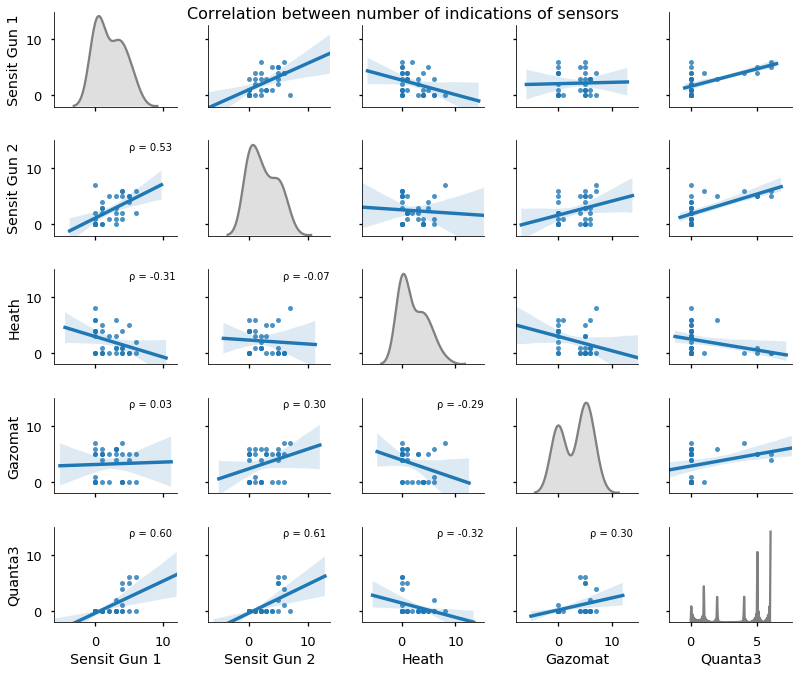

In [41]:
g = sns.pairplot(df_corr_ind.fillna(0), palette='husl', 
                 kind='reg', dropna= True, 
                 diag_kind="kde", height = 1.9, aspect =1.2,
                 plot_kws={"scatter_kws": {'s':25}},
                 diag_kws={'color':'gray'})

g.fig.suptitle("Correlation between number of indications of sensors",
               fontsize = 16,
               backgroundcolor = 'white')

g.axes[0,1].set_ylim((-2,15))
g.axes[1,1].set_ylim((-2,15))
g.axes[2,1].set_ylim((-2,15))
g.axes[3,1].set_ylim((-2,15))
g.axes[4,1].set_ylim((-2,15))

g.map_lower(corrfunc)

replacements = {'gun1_num_ind': 'Sensit Gun 1', 'gun2_num_ind': 'Sensit Gun 2',
                'heath_num_ind': 'Heath', 'gaz_num_ind': 'Gazomat',
                'quanta_num_ind': 'Quanta3'}

for i in range(5):
    for j in range(5):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])



In [42]:
# show if there are correlation between different sensors' area under the curve

df_corr_auc = df_cont_c[['gun1_conc_auc', 'gun2_conc_auc', 'heath_conc_auc',
           'gaz_conc_auc', 'quanta_conc_auc']] 

df_corr_auc.corr()

,gun1_conc_auc,gun2_conc_auc,heath_conc_auc,gaz_conc_auc,quanta_conc_auc
gun1_conc_auc,1.000000,0.184324,-0.131789,0.013957,0.712472
gun2_conc_auc,0.184324,1.000000,-0.035610,0.155681,0.285028
heath_conc_auc,-0.131789,-0.035610,1.000000,0.317069,0.043790
gaz_conc_auc,0.013957,0.155681,0.317069,1.000000,0.456054
quanta_conc_auc,0.712472,0.285028,0.043790,0.456054,1.000000


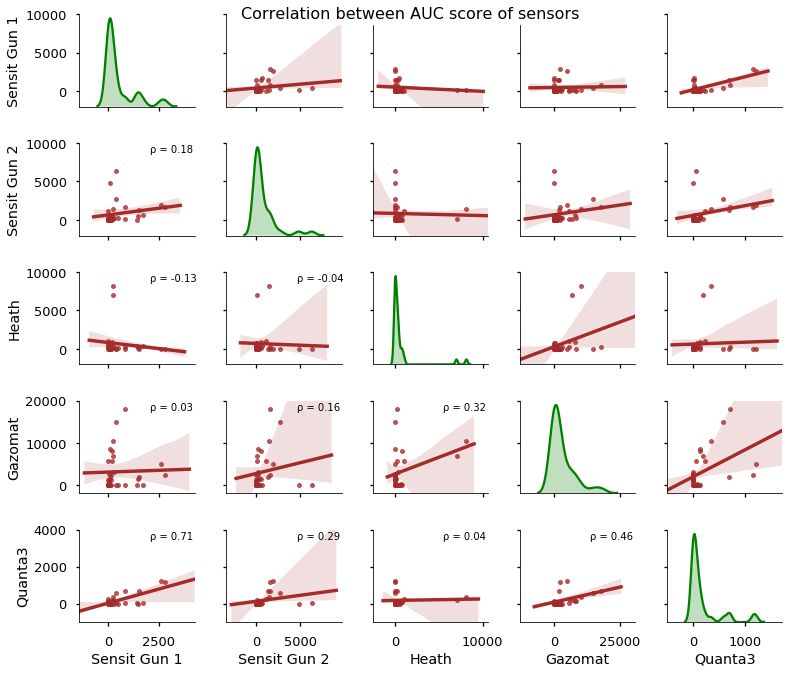

In [43]:
g = sns.pairplot(df_corr_auc.fillna(0), palette='husl', 
                 kind='reg', dropna= False, 
                 diag_kind="kde", height = 1.9, aspect =1.15,
                 plot_kws={"scatter_kws": {'s':25}, 'color':'brown'},
                 diag_kws={"color":'green'})

g.fig.suptitle("Correlation between AUC score of sensors",
               fontsize = 16,
               backgroundcolor = 'white')

g.axes[0,1].set_ylim(-2000, 10000)
g.axes[1,1].set_ylim(-2000, 10000)
g.axes[2,1].set_ylim(-2000, 10000)
g.axes[3,1].set_ylim(-2000, 20000)
g.axes[4,1].set_ylim(-1000, 4000)

g.map_lower(corrfunc)        

replacements = {'gun1_conc_auc': 'Sensit Gun 1', 'gun2_conc_auc': 'Sensit Gun 2',
                'heath_conc_auc': 'Heath', 'gaz_conc_auc': 'Gazomat',
                'quanta_conc_auc': 'Quanta3'}

for i in range(5):
    for j in range(5):
        xlabel = g.axes[i][j].get_xlabel()
        ylabel = g.axes[i][j].get_ylabel()
        if xlabel in replacements.keys():
            g.axes[i][j].set_xlabel(replacements[xlabel])
        if ylabel in replacements.keys():
            g.axes[i][j].set_ylabel(replacements[ylabel])


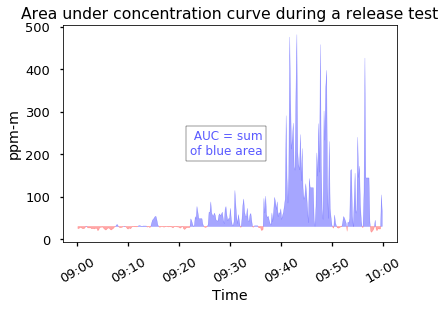

In [44]:
# plot to show area under concentration curve
from matplotlib.dates import DateFormatter

def plot_auc(df, time_column, conc_column, start_time, end_time, bg):
    ''' Plot area under the curve chart to illustrate metric

    '''
    df_int=df[start_time:end_time] # slice dataframe with start and end time
    
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(x = df_int[time_column] , 
             y = df_int[conc_column], 
              marker='.', label="label 1",
             linewidth = 3, color ='blue')
    
    ys = np.array(df_int[conc_column])
    
    ax.fill_between(np.array(df_int[time_column]), np.array(df_int[conc_column]), y2 = bg, where=ys>=bg,
                    interpolate=True, color='blue', alpha=0.35)
    
    ax.fill_between(np.array(df_int[time_column]), np.array(df_int[conc_column]), y2 = bg, where=ys<=bg,
                    interpolate=True, color='red', alpha=0.35)
    
    plt.xticks(rotation=30)
    ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
    plt.title('Area under concentration curve during a release test')
    plt.ylabel('ppm-m')
    plt.xlabel('Time')
    
    plt.annotate(s =' AUC = sum\nof blue area',
             xy = ('2019-08-20 9:00:00', 30),
             xytext = ('2019-08-20 9:22:00', 200),
             color = 'blue', alpha =0.65,
             fontsize ='large',
                bbox=dict(boxstyle='square', fc='white'))
    
    return None

plot_auc(df_sensit_t, 'Date', 'Gun1 (ppm-m)', '2019-08-20 09:00:00', '2019-08-20 10:00:00', bg=gun1_bg)

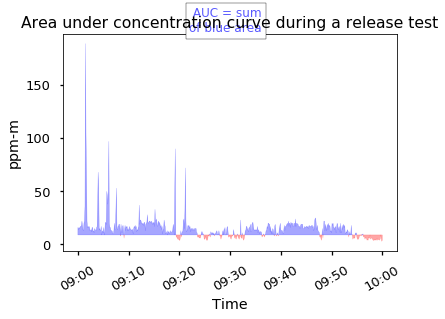

In [45]:
plot_auc(df_heath_t, 'Device Local Time', 'Ch4 Average', '2019-08-20 09:00:00', '2019-08-20 10:00:00', bg=heath_bg )

Text(0.41, 0.35, 'Indication')

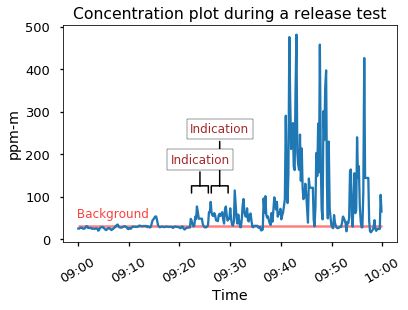

In [46]:
# plot to show concentration 

start_time = '2019-08-20 9:00:00'
end_time = '2019-08-20 10:00:00'

df_sensit_tc = df_sensit_t[start_time:end_time]

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(x = 'Date',
             y = 'Gun1 (ppm-m)',
             data = df_sensit_tc,
             ax = ax
             )

plt.xticks(rotation = 30)
ax.xaxis.set_major_formatter(DateFormatter('%H:%M'))
plt.title('Concentration plot during a release test')
plt.ylabel('ppm-m')
plt.xlabel('Time')

plt.hlines(y = gun1_bg,
           xmin = '2019-08-20 9:00:00',
           xmax = '2019-08-20 10:00:00',
           color = 'red', alpha =0.5,
           linewidth = 2.5)

plt.annotate(s =' Background',
             xy = ('2019-08-20 9:00:00', 30),
             xytext = ('2019-08-20 8:59:00', 50),
             color = 'red', alpha =0.75,
             fontsize ='large')

# Here is the label and arrow code of interest

ax.annotate('Indication', xy=(0.469, 0.25), xytext=(0.469, 0.49), xycoords='axes fraction', 
            fontsize='large', ha='center', va='bottom', color = 'brown',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=0.7, lengthB=0.6', lw=1.5))

ax.annotate('Indication', xy=(0.41, 0.25), xytext=(0.41, 0.35), xycoords='axes fraction', 
            fontsize='large', ha='center', va='bottom', color = 'brown',
            bbox=dict(boxstyle='square', fc='white'),
            arrowprops=dict(arrowstyle='-[, widthB=0.7, lengthB=0.6', lw=1.5))


In [49]:
df_f1 = pd.read_excel(r'C:\Users\GBong\Desktop\Projects\OTD\Stationary Continuous Methane Monitoring System Demo\Instrument Data\F1 values Heath.xlsx')

In [50]:
df_f1

,Month,F1,Std,F2,Std.1
0,July,96.69,9.09,1.43,0.44
1,August,80.90,34.45,1.19,0.62
2,September,93.79,4.05,1.38,0.40
3,October,93.03,3.86,1.40,0.39
4,November,92.11,69.09,1.38,1.57
5,December,75.52,12.09,1.08,0.43


Text(0, 0.5, 'Heath average F1 score')

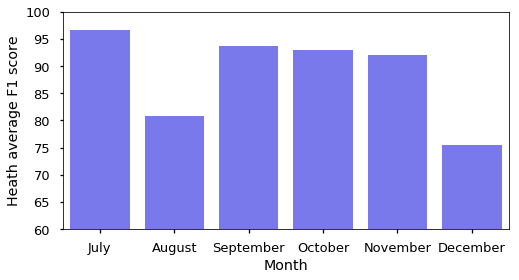

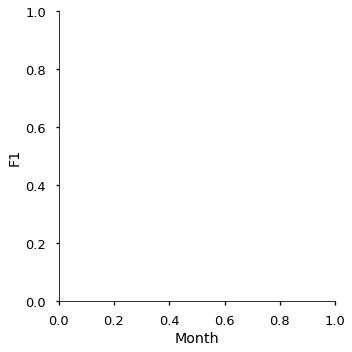

In [65]:

fig, ax = plt.subplots(figsize=(8, 4))
sns.catplot(x='Month', y='F1', data=df_f1, kind ='bar', color='blue', alpha =0.6, ax = ax)
ax.set_ylim(60, 100)
ax.set_ylabel("Heath average F1 score")